# Potato Disease Classification

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village



### Import all the Dependencies

In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Set all the Constants

In [78]:
BASE_DIR = "PlantVillage"
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [79]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
])

dataset = datasets.ImageFolder(root=BASE_DIR, transform=transform)

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

class_names = dataset.classes
print("Classes:", class_names)


Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [80]:
image_batch, labels_batch = next(iter(dataloader))

# batch shape and labels
print("Image batch shape:", image_batch.shape)
print("Labels:", labels_batch.numpy())


Image batch shape: torch.Size([32, 3, 256, 256])
Labels: [1 0 0 0 0 1 0 0 2 1 1 1 1 0 1 0 0 0 1 0 0 1 1 1 2 1 0 1 0 1 1 0]


### Visualize some of the images from our dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.3235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.4285715].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input

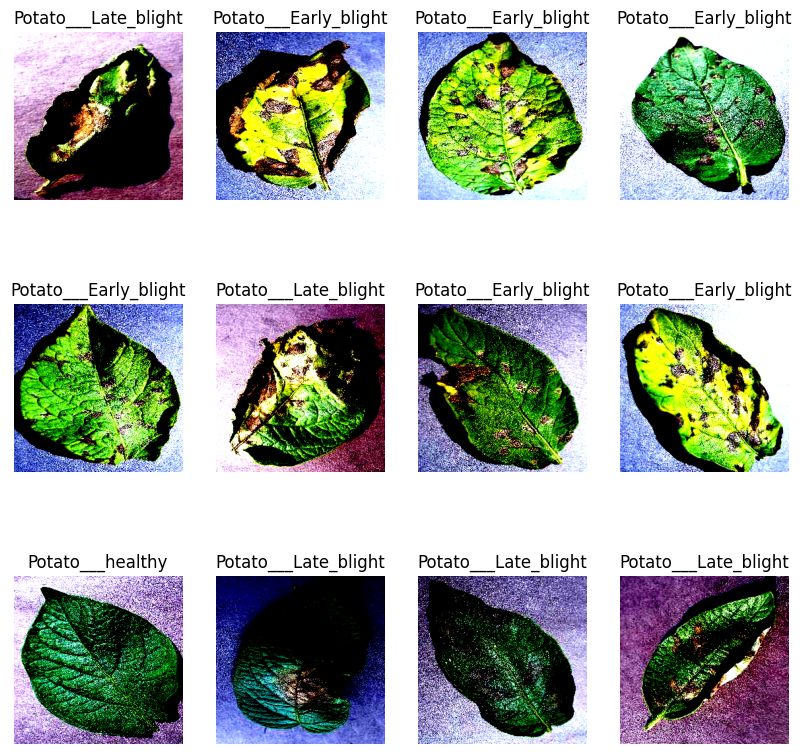

In [81]:
plt.figure(figsize=(10, 10))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)

    # change shape from (C, H, W) to (H, W, C)
    img = image_batch[i].permute(1, 2, 0).numpy()

    plt.imshow(img)
    plt.title(class_names[labels_batch[i].item()])
    plt.axis("off")

plt.show()

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [82]:
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = int(0.1 * len(dataset))    # 10% for validation
test_size = len(dataset) - train_size - val_size  # Remaining for testing

In [83]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

In [84]:
print(f"Train size: {len(train_ds)}")
print(f"Validation size: {len(val_ds)}")
print(f"Test size: {len(test_ds)}")

Train size: 1721
Validation size: 215
Test size: 216


In [85]:
def get_dataset_partitions_pt(dataset, train_split=0.8, val_split=0.1, test_split=0.1, seed=12):
    assert train_split + val_split + test_split == 1, "Splits must sum to 1"
    
    dataset_size = len(dataset)
    
    torch.manual_seed(seed)
    
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    test_size = dataset_size - train_size - val_size 
    
    train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
    
    return train_ds, val_ds, test_ds


In [86]:
train_ds, val_ds, test_ds = get_dataset_partitions_pt(dataset)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train size: {len(train_ds)}")
print(f"Validation size: {len(val_ds)}")
print(f"Test size: {len(test_ds)}")


Train size: 1721
Validation size: 215
Test size: 216


In [87]:

train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = ImageFolder(root="PlantVillage", transform=train_transforms)  # Apply train transforms

class_names = dataset.classes
print(f"Classes: {class_names}")


Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [88]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


In [89]:
resize_and_rescale = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])  # Rescaling(1./255)
])

class PlantDiseaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(PlantDiseaseCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=0)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=0)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=0)
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=0)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 2 * 2, 64)  # Adjust the on actual image size
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [90]:
model = PlantDiseaseCNN(num_classes=3)
model = model.to("cuda" if torch.cuda.is_available() else "cpu")  # Move to GPU if available

print(model)

PlantDiseaseCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)


In [91]:
from helper_functions import accuracy_fn

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [92]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    """Prints difference between start and end time.
    Args:
    start (float): Start time of computation (preferred in timeit format).
    end (float): End time of computation.
    device ([type], optional): Device that compute is running on. Defaults to None.
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [93]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [94]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = EPOCHS
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  train_step(data_loader=train_loader,
    model=model,
    loss_fn=criterion,
    optimizer=optimizer,
    accuracy_fn=accuracy_fn
  )
  test_step(data_loader=test_loader,
    model=model,
    loss_fn=criterion,
    accuracy_fn=accuracy_fn
  )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.84963 | Train accuracy: 70.25%


  2%|▏         | 1/50 [01:26<1:10:46, 86.66s/it]

Test loss: 0.77051 | Test accuracy: 77.53%

Epoch: 1
---------
Train loss: 0.72945 | Train accuracy: 82.13%


  4%|▍         | 2/50 [02:48<1:07:08, 83.92s/it]

Test loss: 0.76613 | Test accuracy: 78.12%

Epoch: 2
---------
Train loss: 0.74416 | Train accuracy: 80.72%


  6%|▌         | 3/50 [04:22<1:09:17, 88.46s/it]

Test loss: 0.79614 | Test accuracy: 75.30%

Epoch: 3
---------
Train loss: 0.81186 | Train accuracy: 74.01%


  8%|▊         | 4/50 [06:20<1:16:53, 100.29s/it]

Test loss: 0.75762 | Test accuracy: 79.76%

Epoch: 4
---------
Train loss: 0.72936 | Train accuracy: 82.13%


 10%|█         | 5/50 [08:19<1:20:04, 106.77s/it]

Test loss: 0.80499 | Test accuracy: 74.55%

Epoch: 5
---------
Train loss: 0.77659 | Train accuracy: 77.50%


 12%|█▏        | 6/50 [10:29<1:24:02, 114.61s/it]

Test loss: 0.75508 | Test accuracy: 79.46%

Epoch: 6
---------
Train loss: 0.75376 | Train accuracy: 79.52%


 14%|█▍        | 7/50 [12:31<1:23:57, 117.15s/it]

Test loss: 0.78250 | Test accuracy: 76.93%

Epoch: 7
---------
Train loss: 0.79349 | Train accuracy: 75.67%


 16%|█▌        | 8/50 [14:27<1:21:45, 116.80s/it]

Test loss: 0.76818 | Test accuracy: 78.27%

Epoch: 8
---------
Train loss: 0.72349 | Train accuracy: 82.77%


 18%|█▊        | 9/50 [16:29<1:20:52, 118.35s/it]

Test loss: 0.82845 | Test accuracy: 72.32%

Epoch: 9
---------
Train loss: 0.76859 | Train accuracy: 78.22%


 20%|██        | 10/50 [18:19<1:17:09, 115.74s/it]

Test loss: 0.79695 | Test accuracy: 75.45%

Epoch: 10
---------
Train loss: 0.74090 | Train accuracy: 81.01%


 22%|██▏       | 11/50 [21:05<1:25:19, 131.27s/it]

Test loss: 0.82229 | Test accuracy: 72.77%

Epoch: 11
---------
Train loss: 0.80351 | Train accuracy: 74.88%


 24%|██▍       | 12/50 [23:33<1:26:15, 136.19s/it]

Test loss: 0.84812 | Test accuracy: 70.24%

Epoch: 12
---------
Train loss: 0.81612 | Train accuracy: 73.56%


 26%|██▌       | 13/50 [25:02<1:15:17, 122.10s/it]

Test loss: 0.99493 | Test accuracy: 55.65%

Epoch: 13
---------
Train loss: 0.76224 | Train accuracy: 78.87%


 28%|██▊       | 14/50 [26:22<1:05:37, 109.37s/it]

Test loss: 0.77466 | Test accuracy: 77.68%

Epoch: 14
---------
Train loss: 0.75305 | Train accuracy: 79.87%


 30%|███       | 15/50 [27:41<58:28, 100.24s/it]  

Test loss: 0.73746 | Test accuracy: 81.40%

Epoch: 15
---------
Train loss: 0.73878 | Train accuracy: 81.26%


 32%|███▏      | 16/50 [29:03<53:40, 94.71s/it] 

Test loss: 0.86841 | Test accuracy: 68.30%

Epoch: 16
---------
Train loss: 0.76481 | Train accuracy: 78.63%


 34%|███▍      | 17/50 [30:24<49:48, 90.57s/it]

Test loss: 0.83716 | Test accuracy: 71.43%

Epoch: 17
---------
Train loss: 0.80376 | Train accuracy: 74.77%


 36%|███▌      | 18/50 [31:43<46:22, 86.94s/it]

Test loss: 0.76424 | Test accuracy: 78.72%

Epoch: 18
---------
Train loss: 0.70907 | Train accuracy: 84.24%


 38%|███▊      | 19/50 [33:02<43:43, 84.63s/it]

Test loss: 0.75531 | Test accuracy: 79.61%

Epoch: 19
---------
Train loss: 0.76839 | Train accuracy: 78.28%


 40%|████      | 20/50 [34:21<41:30, 83.02s/it]

Test loss: 0.98137 | Test accuracy: 56.99%

Epoch: 20
---------
Train loss: 0.94506 | Train accuracy: 60.57%


 42%|████▏     | 21/50 [35:47<40:31, 83.84s/it]

Test loss: 0.75038 | Test accuracy: 80.21%

Epoch: 21
---------
Train loss: 0.79762 | Train accuracy: 75.38%


 44%|████▍     | 22/50 [37:05<38:19, 82.14s/it]

Test loss: 0.83716 | Test accuracy: 71.43%

Epoch: 22
---------
Train loss: 0.81547 | Train accuracy: 73.60%


 46%|████▌     | 23/50 [38:22<36:14, 80.53s/it]

Test loss: 0.83716 | Test accuracy: 71.43%

Epoch: 23
---------
Train loss: 0.81482 | Train accuracy: 73.66%


 48%|████▊     | 24/50 [39:40<34:34, 79.78s/it]

Test loss: 0.83716 | Test accuracy: 71.43%

Epoch: 24
---------
Train loss: 0.81499 | Train accuracy: 73.65%


 50%|█████     | 25/50 [40:56<32:46, 78.67s/it]

Test loss: 0.83716 | Test accuracy: 71.43%

Epoch: 25
---------
Train loss: 0.81563 | Train accuracy: 73.58%


 52%|█████▏    | 26/50 [42:12<31:12, 78.03s/it]

Test loss: 0.83716 | Test accuracy: 71.43%

Epoch: 26
---------
Train loss: 0.81482 | Train accuracy: 73.66%


 54%|█████▍    | 27/50 [43:31<29:56, 78.09s/it]

Test loss: 0.83716 | Test accuracy: 71.43%

Epoch: 27
---------
Train loss: 0.81580 | Train accuracy: 73.56%


 56%|█████▌    | 28/50 [44:50<28:44, 78.41s/it]

Test loss: 0.83716 | Test accuracy: 71.43%

Epoch: 28
---------
Train loss: 0.81466 | Train accuracy: 73.68%


 58%|█████▊    | 29/50 [46:09<27:32, 78.70s/it]

Test loss: 0.83716 | Test accuracy: 71.43%

Epoch: 29
---------
Train loss: 0.81450 | Train accuracy: 73.69%


 60%|██████    | 30/50 [47:28<26:16, 78.85s/it]

Test loss: 0.83716 | Test accuracy: 71.43%

Epoch: 30
---------
Train loss: 0.81531 | Train accuracy: 73.61%


 62%|██████▏   | 31/50 [48:48<25:00, 78.97s/it]

Test loss: 0.83716 | Test accuracy: 71.43%

Epoch: 31
---------
Train loss: 0.81596 | Train accuracy: 73.55%


 64%|██████▍   | 32/50 [50:08<23:47, 79.31s/it]

Test loss: 0.83716 | Test accuracy: 71.43%

Epoch: 32
---------
Train loss: 0.81547 | Train accuracy: 73.60%


 66%|██████▌   | 33/50 [51:26<22:21, 78.92s/it]

Test loss: 0.83716 | Test accuracy: 71.43%

Epoch: 33
---------
Train loss: 0.81515 | Train accuracy: 73.63%


 68%|██████▊   | 34/50 [52:43<20:56, 78.56s/it]

Test loss: 0.83716 | Test accuracy: 71.43%

Epoch: 34
---------
Train loss: 0.81547 | Train accuracy: 73.60%


 70%|███████   | 35/50 [54:02<19:36, 78.43s/it]

Test loss: 0.83716 | Test accuracy: 71.43%

Epoch: 35
---------
Train loss: 0.81531 | Train accuracy: 73.61%


 72%|███████▏  | 36/50 [55:21<18:23, 78.80s/it]

Test loss: 0.83716 | Test accuracy: 71.43%

Epoch: 36
---------
Train loss: 0.80209 | Train accuracy: 74.94%


 74%|███████▍  | 37/50 [56:40<17:02, 78.69s/it]

Test loss: 0.81335 | Test accuracy: 73.81%

Epoch: 37
---------
Train loss: 0.79522 | Train accuracy: 75.62%


 76%|███████▌  | 38/50 [57:59<15:45, 78.78s/it]

Test loss: 0.81298 | Test accuracy: 73.81%

Epoch: 38
---------
Train loss: 0.79291 | Train accuracy: 75.82%


 78%|███████▊  | 39/50 [59:17<14:25, 78.72s/it]

Test loss: 0.85205 | Test accuracy: 69.94%

Epoch: 39
---------
Train loss: 1.04074 | Train accuracy: 51.07%


 80%|████████  | 40/50 [1:00:36<13:08, 78.82s/it]

Test loss: 1.09348 | Test accuracy: 45.98%

Epoch: 40
---------
Train loss: 0.99328 | Train accuracy: 55.78%


 82%|████████▏ | 41/50 [1:01:55<11:49, 78.81s/it]

Test loss: 1.02912 | Test accuracy: 52.23%

Epoch: 41
---------
Train loss: 0.88228 | Train accuracy: 66.93%


 84%|████████▍ | 42/50 [1:03:13<10:28, 78.54s/it]

Test loss: 0.86841 | Test accuracy: 68.30%

Epoch: 42
---------
Train loss: 0.82795 | Train accuracy: 72.35%


 86%|████████▌ | 43/50 [1:04:35<09:17, 79.67s/it]

Test loss: 0.86841 | Test accuracy: 68.30%

Epoch: 43
---------
Train loss: 0.82714 | Train accuracy: 72.43%


 88%|████████▊ | 44/50 [1:06:03<08:13, 82.22s/it]

Test loss: 0.86841 | Test accuracy: 68.30%

Epoch: 44
---------
Train loss: 0.82746 | Train accuracy: 72.40%


 90%|█████████ | 45/50 [1:07:32<06:59, 83.96s/it]

Test loss: 0.86841 | Test accuracy: 68.30%

Epoch: 45
---------
Train loss: 0.82763 | Train accuracy: 72.38%


 92%|█████████▏| 46/50 [1:08:56<05:36, 84.03s/it]

Test loss: 0.86841 | Test accuracy: 68.30%

Epoch: 46
---------
Train loss: 0.82779 | Train accuracy: 72.37%


 94%|█████████▍| 47/50 [1:10:22<04:14, 84.73s/it]

Test loss: 0.86841 | Test accuracy: 68.30%

Epoch: 47
---------
Train loss: 0.82714 | Train accuracy: 72.43%


 96%|█████████▌| 48/50 [1:11:55<02:54, 87.20s/it]

Test loss: 0.86841 | Test accuracy: 68.30%

Epoch: 48
---------
Train loss: 0.82698 | Train accuracy: 72.45%


 98%|█████████▊| 49/50 [1:13:25<01:27, 87.91s/it]

Test loss: 0.86841 | Test accuracy: 68.30%

Epoch: 49
---------
Train loss: 0.82779 | Train accuracy: 72.37%


100%|██████████| 50/50 [1:14:47<00:00, 89.75s/it]

Test loss: 0.86841 | Test accuracy: 68.30%

Train time on cpu: 4487.295 seconds


In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model results with device-agnostic code
model_1_results = eval_model(model=model, data_loader=test_loader,
    loss_fn=criterion, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

{'model_name': 'PlantDiseaseCNN',
 'model_loss': 0.8684090375900269,
 'model_acc': 68.30357142857143}